### Citations (APA Style):

- Jakkula, V.R. (2011). Tutorial on Support Vector Machine ( SVM ).

- Auria, Laura and Moro, R. A., Support Vector Machines (SVM) as a Technique for Solvency Analysis (August 1, 2008). DIW Berlin Discussion Paper No. 811, Available at SSRN: https://ssrn.com/abstract=1424949 or http://dx.doi.org/10.2139/ssrn.1424949

[Read more about SVMs by clicking here.](https://scikit-learn.org/stable/modules/svm.html)

Import all required modules

In [1]:
# Add local modules' path
# Restart notebook if you modify these imports' files
import os
import sys

module_path = os.path.abspath(os.path.join("..", "common"))

if module_path not in sys.path:
    sys.path.append(module_path)

# Actual imports
from common import kUtils
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

Get the split data

In [2]:
X_train: np.ndarray; X_test: np.ndarray; X_val: np.ndarray; y_train: np.ndarray; y_test: np.ndarray; y_val: np.ndarray;

X_train, X_test, X_val, y_train, y_test, y_val = kUtils.get_split_data()


In [3]:
model: svm.SVC = svm.SVC(kernel="linear")

classifier: svm.SVC = model.fit(X=X_train, y=y_train)

In [4]:
score: float = classifier.score(X=X_test, y=y_test)

print(f"SVM score: {score}")

SVM score: 0.9908571428571429


PC1 explains 98.59% of the variance
PC2 explains 0.31% of the variance
Variance explained by all principal components: 98.90%


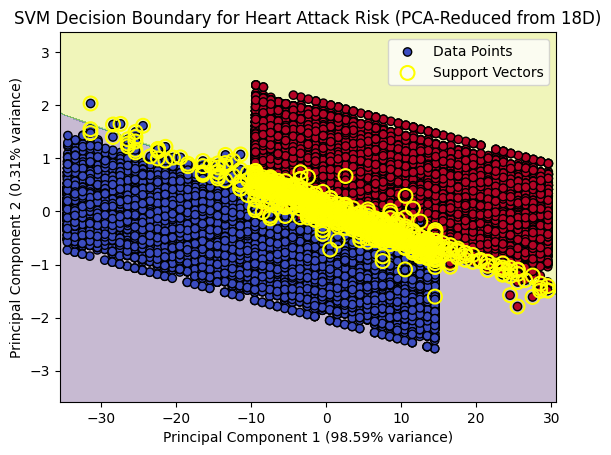

In [ ]:
support_vectors: np.ndarray = classifier.support_vectors_

pca: PCA = PCA(n_components=2)
X_pca: np.ndarray = pca.fit_transform(X_train)
support_vectors_pca: np.ndarray = pca.transform(support_vectors)

explained_variance: np.ndarray = pca.explained_variance_ratio_ * 100
print(f"PC1 explains {explained_variance[0]:.2f}% of the variance")
print(f"PC2 explains {explained_variance[1]:.2f}% of the variance")
print(f"Variance explained by all principal components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

h: float; x_min: float; x_max: float; y_min: float; y_max: float;

h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx: np.ndarray; yy: np.ndarray;

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z: np.ndarray = classifier.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm, label="Data Points")
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], 
            facecolors='none', edgecolors='yellow', linewidths=1.5, s=100, label="Support Vectors")
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% variance)')
plt.title('SVM Decision Boundary for Heart Attack Risk (PCA-Reduced from 18D)')
plt.legend()
plt.show()

In [6]:
import pandas as pd

feature_list: list[str] = kUtils.get_feature_list()

feature_importance: pd.DataFrame = pd.DataFrame(pca.components_, columns=[feature_list[i] for i in range(len(X_train[0,]))], index=['PC1', 'PC2'])
feature_importance = feature_importance.sort_values(by=["PC1", "PC2"], axis="columns", ascending=False)

print("Feature Contributions to Principal Components:\n", feature_importance.T)


Feature Contributions to Principal Components:
                           PC1       PC2
Age                  0.999281 -0.037867
Palpitations         0.011203  0.280678
Dizziness            0.011133  0.282587
Cold_Sweats_Nausea   0.011094  0.282134
Chest_Pain           0.011082  0.280611
Fatigue              0.011055  0.283450
Pain_Arms_Jaw_Back   0.011009  0.285782
Swelling             0.010950  0.283500
Shortness_of_Breath  0.010853  0.282767
High_BP              0.007579  0.208341
Sedentary_Lifestyle  0.007528  0.202734
High_Cholesterol     0.007411  0.203167
Smoking              0.007360  0.202297
Diabetes             0.007312  0.201617
Chronic_Stress       0.007281  0.208102
Obesity              0.007163  0.204566
Family_History       0.007030  0.206343
Gender               0.005474  0.155419
